# Preliminaries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.manifold import TSNE

from scipy.interpolate import interp1d
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,  davies_bouldin_score
from scipy.spatial.distance import cdist
from kneed import KneeLocator

from tqdm import tqdm

# Data Preprocessing

In [2]:
df = pd.read_csv('C:/Users/Francia/Desktop/data/Capstone/consolidated_csv_03SBPL_G01.csv')
df.head()

,RUN_TIME,MKT_TYPE,REGION_NAME,ZONE_NAME,RESOURCE_NAME,TIME_INTERVAL,START_TIME,END_TIME,MP_NAME,PRICE1,...,RR_BREAK_QUANTITY3,RR_UP3,RR_DOWN3,RR_BREAK_QUANTITY4,RR_UP4,RR_DOWN4,RR_BREAK_QUANTITY5,RR_UP5,RR_DOWN5,Unnamed: 46
0,06/26/2021,RTD,CLUZ,SLUZON,03SBPL_G01,06/26/2021 12:05:00 AM,06/26/2021,06/26/2021 12:05:00 AM,SBPLC,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,06/26/2021 12:05:00 AM,RTD,CLUZ,SLUZON,03SBPL_G01,06/26/2021 12:10:00 AM,06/26/2021 12:05:00 AM,06/26/2021 12:10:00 AM,SBPLC,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,06/26/2021 12:10:00 AM,RTD,CLUZ,SLUZON,03SBPL_G01,06/26/2021 12:15:00 AM,06/26/2021 12:10:00 AM,06/26/2021 12:15:00 AM,SBPLC,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,06/26/2021 12:15:00 AM,RTD,CLUZ,SLUZON,03SBPL_G01,06/26/2021 12:20:00 AM,06/26/2021 12:15:00 AM,06/26/2021 12:20:00 AM,SBPLC,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,06/26/2021 12:20:00 AM,RTD,CLUZ,SLUZON,03SBPL_G01,06/26/2021 12:25:00 AM,06/26/2021 12:20:00 AM,06/26/2021 12:25:00 AM,SBPLC,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Dropping of columns

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210807 entries, 0 to 210806
Data columns (total 47 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   RUN_TIME            210807 non-null  object 
 1   MKT_TYPE            210807 non-null  object 
 2   REGION_NAME         210807 non-null  object 
 3   ZONE_NAME           210807 non-null  object 
 4   RESOURCE_NAME       210807 non-null  object 
 5   TIME_INTERVAL       210807 non-null  object 
 6   START_TIME          210807 non-null  object 
 7   END_TIME            210807 non-null  object 
 8   MP_NAME             206235 non-null  object 
 9   PRICE1              210807 non-null  float64
 10  QUANTITY1           210807 non-null  float64
 11  PRICE2              210807 non-null  float64
 12  QUANTITY2           210807 non-null  float64
 13  PRICE3              210597 non-null  float64
 14  QUANTITY3           210597 non-null  float64
 15  PRICE4              600 non-null  

In [4]:
# Define the columns containing price-quantity pairs and timestamps
price_columns = [f'PRICE{i}' for i in range(1, 12)]
quantity_columns = [f'QUANTITY{i}' for i in range(1, 12)]

# Corrected line with tuple comprehension
selected_columns = ['RUN_TIME'] + [price for price in price_columns] + [quantity for quantity in quantity_columns]

In [5]:
# Apply the selection to the filtered DataFrame
result_df = df[selected_columns]
result_df

,RUN_TIME,PRICE1,PRICE2,PRICE3,PRICE4,PRICE5,PRICE6,PRICE7,PRICE8,PRICE9,...,QUANTITY2,QUANTITY3,QUANTITY4,QUANTITY5,QUANTITY6,QUANTITY7,QUANTITY8,QUANTITY9,QUANTITY10,QUANTITY11
0,06/26/2021,0.0,0.0,1893.3,NaN,NaN,NaN,NaN,NaN,NaN,...,180.0,455.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,06/26/2021 12:05:00 AM,0.0,0.0,1893.3,NaN,NaN,NaN,NaN,NaN,NaN,...,180.0,455.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,06/26/2021 12:10:00 AM,0.0,0.0,1893.3,NaN,NaN,NaN,NaN,NaN,NaN,...,180.0,455.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,06/26/2021 12:15:00 AM,0.0,0.0,1893.3,NaN,NaN,NaN,NaN,NaN,NaN,...,180.0,455.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,06/26/2021 12:20:00 AM,0.0,0.0,1893.3,NaN,NaN,NaN,NaN,NaN,NaN,...,180.0,455.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210802,09/25/2023 11:35:00 PM,-9999.0,-9999.0,5828.7,NaN,NaN,NaN,NaN,NaN,NaN,...,180.0,455.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
210803,09/25/2023 11:40:00 PM,-9999.0,-9999.0,5828.7,NaN,NaN,NaN,NaN,NaN,NaN,...,180.0,455.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
210804,09/25/2023 11:45:00 PM,-9999.0,-9999.0,5828.7,NaN,NaN,NaN,NaN,NaN,NaN,...,180.0,455.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
210805,09/25/2023 11:50:00 PM,-9999.0,-9999.0,5828.7,NaN,NaN,NaN,NaN,NaN,NaN,...,180.0,455.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df[selected_columns].describe()

,PRICE1,PRICE2,PRICE3,PRICE4,PRICE5,PRICE6,PRICE7,PRICE8,PRICE9,PRICE10,...,QUANTITY2,QUANTITY3,QUANTITY4,QUANTITY5,QUANTITY6,QUANTITY7,QUANTITY8,QUANTITY9,QUANTITY10,QUANTITY11
count,210807.000000,210807.000000,210597.00000,600.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,210807.000000,210597.000000,600.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,-9597.725185,-9597.725185,5071.60636,9148.452000,NaN,NaN,NaN,NaN,NaN,NaN,...,180.378749,453.237848,455.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,1962.484056,1962.484056,3243.01400,1222.468978,NaN,NaN,NaN,NaN,NaN,NaN,...,8.055457,16.994429,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,-9999.000000,-9999.000000,-9998.00000,3264.900000,NaN,NaN,NaN,NaN,NaN,NaN,...,5.000000,181.000000,455.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,-9999.000000,-9999.000000,2688.90000,9166.300000,NaN,NaN,NaN,NaN,NaN,NaN,...,180.000000,455.000000,455.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,-9999.000000,-9999.000000,5726.50000,9166.300000,NaN,NaN,NaN,NaN,NaN,NaN,...,180.000000,455.000000,455.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,-9999.000000,-9999.000000,7995.20000,9620.900000,NaN,NaN,NaN,NaN,NaN,NaN,...,180.000000,455.000000,455.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,0.000000,0.000000,10060.40000,9620.900000,NaN,NaN,NaN,NaN,NaN,NaN,...,442.500000,455.000000,455.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
#change Uppercase to lowercase
result_df.columns = result_df.columns.str.lower()

## FFill NaNs with last Price-Quantity Bid

In [8]:
# Forward fill from the first non-null value in each row for the price columns
result_df.loc[:, 'price1':'price11'] = result_df.loc[:, 'price1':'price11'].apply(lambda row: row.ffill(), axis=1)

# Forward fill from the first non-null value in each row for the quantity columns
result_df.loc[:, 'quantity1':'quantity11'] = result_df.loc[:, 'quantity1':'quantity11'].apply(lambda row: row.ffill(), axis=1)

## TAKES 30 SECONDS TO RUN
result_df

,run_time,price1,price2,price3,price4,price5,price6,price7,price8,price9,...,quantity2,quantity3,quantity4,quantity5,quantity6,quantity7,quantity8,quantity9,quantity10,quantity11
0,06/26/2021,0.0,0.0,1893.3,1893.3,1893.3,1893.3,1893.3,1893.3,1893.3,...,180.0,455.0,455.0,455.0,455.0,455.0,455.0,455.0,455.0,455.0
1,06/26/2021 12:05:00 AM,0.0,0.0,1893.3,1893.3,1893.3,1893.3,1893.3,1893.3,1893.3,...,180.0,455.0,455.0,455.0,455.0,455.0,455.0,455.0,455.0,455.0
2,06/26/2021 12:10:00 AM,0.0,0.0,1893.3,1893.3,1893.3,1893.3,1893.3,1893.3,1893.3,...,180.0,455.0,455.0,455.0,455.0,455.0,455.0,455.0,455.0,455.0
3,06/26/2021 12:15:00 AM,0.0,0.0,1893.3,1893.3,1893.3,1893.3,1893.3,1893.3,1893.3,...,180.0,455.0,455.0,455.0,455.0,455.0,455.0,455.0,455.0,455.0
4,06/26/2021 12:20:00 AM,0.0,0.0,1893.3,1893.3,1893.3,1893.3,1893.3,1893.3,1893.3,...,180.0,455.0,455.0,455.0,455.0,455.0,455.0,455.0,455.0,455.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210802,09/25/2023 11:35:00 PM,-9999.0,-9999.0,5828.7,5828.7,5828.7,5828.7,5828.7,5828.7,5828.7,...,180.0,455.0,455.0,455.0,455.0,455.0,455.0,455.0,455.0,455.0
210803,09/25/2023 11:40:00 PM,-9999.0,-9999.0,5828.7,5828.7,5828.7,5828.7,5828.7,5828.7,5828.7,...,180.0,455.0,455.0,455.0,455.0,455.0,455.0,455.0,455.0,455.0
210804,09/25/2023 11:45:00 PM,-9999.0,-9999.0,5828.7,5828.7,5828.7,5828.7,5828.7,5828.7,5828.7,...,180.0,455.0,455.0,455.0,455.0,455.0,455.0,455.0,455.0,455.0
210805,09/25/2023 11:50:00 PM,-9999.0,-9999.0,5828.7,5828.7,5828.7,5828.7,5828.7,5828.7,5828.7,...,180.0,455.0,455.0,455.0,455.0,455.0,455.0,455.0,455.0,455.0


## Filter to 2022 data

In [9]:
result_df['run_time'] = result_df['run_time'].astype(str)

C:\Users\Francia\AppData\Local\Temp\ipykernel_27904\2012798107.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df['run_time'] = result_df['run_time'].astype(str)


In [10]:
df_2022 = result_df[result_df['run_time'].str.contains('2022')]
df_2022.head()

,run_time,price1,price2,price3,price4,price5,price6,price7,price8,price9,...,quantity2,quantity3,quantity4,quantity5,quantity6,quantity7,quantity8,quantity9,quantity10,quantity11
47238,01/19/2022 09:00:00 AM,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,...,60.0,60.0,60.0,60.0,60.0,60.0,60.0,60.0,60.0,60.0
47239,01/19/2022 09:05:00 AM,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,...,60.0,60.0,60.0,60.0,60.0,60.0,60.0,60.0,60.0,60.0
47240,01/19/2022 09:10:00 AM,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,...,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0
47241,01/19/2022 09:15:00 AM,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,...,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0
47242,01/19/2022 09:20:00 AM,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,...,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0,15.0


In [11]:
df_2022.describe()

,price1,price2,price3,price4,price5,price6,price7,price8,price9,price10,...,quantity2,quantity3,quantity4,quantity5,quantity6,quantity7,quantity8,quantity9,quantity10,quantity11
count,94062.0,94062.0,94062.000000,94062.000000,94062.000000,94062.000000,94062.000000,94062.000000,94062.000000,94062.000000,...,94062.000000,94062.000000,94062.000000,94062.000000,94062.000000,94062.000000,94062.000000,94062.000000,94062.000000,94062.000000
mean,-9999.0,-9999.0,6397.927410,6415.021803,6415.021803,6415.021803,6415.021803,6415.021803,6415.021803,6415.021803,...,179.895494,452.171185,453.120346,453.120346,453.120346,453.120346,453.120346,453.120346,453.120346,453.120346
std,0.0,0.0,2539.233896,2549.986104,2549.986104,2549.986104,2549.986104,2549.986104,2549.986104,2549.986104,...,4.508718,22.473729,19.037230,19.037230,19.037230,19.037230,19.037230,19.037230,19.037230,19.037230
min,-9999.0,-9999.0,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
25%,-9999.0,-9999.0,4649.300000,4649.300000,4649.300000,4649.300000,4649.300000,4649.300000,4649.300000,4649.300000,...,180.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000
50%,-9999.0,-9999.0,6272.100000,6272.100000,6272.100000,6272.100000,6272.100000,6272.100000,6272.100000,6272.100000,...,180.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000
75%,-9999.0,-9999.0,8304.100000,8415.700000,8415.700000,8415.700000,8415.700000,8415.700000,8415.700000,8415.700000,...,180.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000
max,-9999.0,-9999.0,10060.400000,10060.400000,10060.400000,10060.400000,10060.400000,10060.400000,10060.400000,10060.400000,...,330.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000


## Normalize quantity values

In [12]:
from sklearn.preprocessing import MinMaxScaler

# Extract only the quantity columns for normalization
quantity_columns = [f'quantity{i}' for i in range(1, 12)]

# Flatten the DataFrame and extract only quantity columns
flattened_quantities = df_2022[quantity_columns].values.flatten()

# Reshape the flattened quantities to a column vector
flattened_quantities = flattened_quantities.reshape(-1, 1)

# Use MinMaxScaler on the flattened quantities
scaler = MinMaxScaler()
scaled_quantities = scaler.fit_transform(flattened_quantities)

# Reshape the scaled quantities to match the original DataFrame shape
scaled_quantities = scaled_quantities.reshape(df_2022[quantity_columns].shape)

# Update the DataFrame with the scaled values
df_2022.loc[:, quantity_columns] = scaled_quantities

In [13]:
df_2022.head()

,run_time,price1,price2,price3,price4,price5,price6,price7,price8,price9,...,quantity2,quantity3,quantity4,quantity5,quantity6,quantity7,quantity8,quantity9,quantity10,quantity11
47238,01/19/2022 09:00:00 AM,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,...,0.131868,0.131868,0.131868,0.131868,0.131868,0.131868,0.131868,0.131868,0.131868,0.131868
47239,01/19/2022 09:05:00 AM,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,...,0.131868,0.131868,0.131868,0.131868,0.131868,0.131868,0.131868,0.131868,0.131868,0.131868
47240,01/19/2022 09:10:00 AM,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,...,0.032967,0.032967,0.032967,0.032967,0.032967,0.032967,0.032967,0.032967,0.032967,0.032967
47241,01/19/2022 09:15:00 AM,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,...,0.032967,0.032967,0.032967,0.032967,0.032967,0.032967,0.032967,0.032967,0.032967,0.032967
47242,01/19/2022 09:20:00 AM,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,...,0.032967,0.032967,0.032967,0.032967,0.032967,0.032967,0.032967,0.032967,0.032967,0.032967


In [14]:
df_2022.describe()

,price1,price2,price3,price4,price5,price6,price7,price8,price9,price10,...,quantity2,quantity3,quantity4,quantity5,quantity6,quantity7,quantity8,quantity9,quantity10,quantity11
count,94062.0,94062.0,94062.000000,94062.000000,94062.000000,94062.000000,94062.000000,94062.000000,94062.000000,94062.000000,...,94062.000000,94062.000000,94062.000000,94062.000000,94062.000000,94062.000000,94062.000000,94062.000000,94062.000000,94062.000000
mean,-9999.0,-9999.0,6397.927410,6415.021803,6415.021803,6415.021803,6415.021803,6415.021803,6415.021803,6415.021803,...,0.395375,0.993783,0.995869,0.995869,0.995869,0.995869,0.995869,0.995869,0.995869,0.995869
std,0.0,0.0,2539.233896,2549.986104,2549.986104,2549.986104,2549.986104,2549.986104,2549.986104,2549.986104,...,0.009909,0.049393,0.041840,0.041840,0.041840,0.041840,0.041840,0.041840,0.041840,0.041840
min,-9999.0,-9999.0,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,...,0.010989,0.010989,0.010989,0.010989,0.010989,0.010989,0.010989,0.010989,0.010989,0.010989
25%,-9999.0,-9999.0,4649.300000,4649.300000,4649.300000,4649.300000,4649.300000,4649.300000,4649.300000,4649.300000,...,0.395604,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,-9999.0,-9999.0,6272.100000,6272.100000,6272.100000,6272.100000,6272.100000,6272.100000,6272.100000,6272.100000,...,0.395604,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
75%,-9999.0,-9999.0,8304.100000,8415.700000,8415.700000,8415.700000,8415.700000,8415.700000,8415.700000,8415.700000,...,0.395604,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,-9999.0,-9999.0,10060.400000,10060.400000,10060.400000,10060.400000,10060.400000,10060.400000,10060.400000,10060.400000,...,0.725275,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Obtain bidding curve and price series for clustering

In [15]:
# Assuming df is your DataFrame with price-quantity pairs in each row
test_df = df_2022#.iloc[:10000]

# Create empty lists to store data for all stepwise curves
all_quantities = []
all_prices = []
all_intp_quantities = []
all_intp_prices = []

# Iterate through each row
for index, row in tqdm(test_df.iterrows(), total=len(test_df), desc='Processing rows'):
    # Extract price and quantity columns for the current row
    prices = row.filter(like='price')
    quantities = row.filter(like='quantity')

    # Sort data by quantity
    sorted_data = sorted(zip(quantities, prices))
    quantities, prices = zip(*sorted_data)

    # Interpolate prices for regular quantity intervals
    step_fx = interp1d(quantities, prices, kind='next', fill_value='extrapolate')
    step = df_2022['quantity11'].max() / 10

    # Create a finer quantity range for interpolation
    intp_quantities = np.arange(df_2022['quantity1'].min(), df_2022['quantity11'].max() + 0.1, step)
    
    # Get interpolated prices
    intp_prices = step_fx(intp_quantities)
    
    # Set a condition to handle quantities beyond the maximum in the raw data
    max_quantity_interval = max(quantities)
    intp_prices[intp_quantities > max_quantity_interval] = 33000
    
    # Append data to lists
    all_quantities.append(quantities)
    all_prices.append(prices)
    all_intp_quantities.append(intp_quantities)
    all_intp_prices.append(intp_prices)

Processing rows: 100%|█████████████████████████████████████████████████████████| 94062/94062 [01:30<00:00, 1041.87it/s]


In [16]:
# Convert the interpolated prices into price series
price_series = np.array(all_intp_prices)
price_series

array([[-9999. , -9999. , 33000. , ..., 33000. , 33000. , 33000. ],
       [-9999. , -9999. , 33000. , ..., 33000. , 33000. , 33000. ],
       [-9999. , 33000. , 33000. , ..., 33000. , 33000. , 33000. ],
       ...,
       [-9999. , -9999. , -9999. , ...,  8859.1,  8859.1,  8859.1],
       [-9999. , -9999. , -9999. , ...,  8859.1,  8859.1,  8859.1],
       [-9999. , -9999. , -9999. , ...,  8859.1,  8859.1,  8859.1]])

In [17]:
# Export price series to a new graph - remember to change the powerplant name

# Specify the CSV file path
csv_file_path = 'C:/Users/Francia/Desktop/data/Capstone/consolidated_csv_03SBPL_G01_price_series.csv'

# Save the array to a CSV file
np.savetxt(csv_file_path, price_series, delimiter=',')

print(f"Array has been saved to {csv_file_path}")

Array has been saved to C:/Users/Francia/Desktop/data/Capstone/consolidated_csv_03SBPL_G01_price_series.csv


In [18]:
# # Plot all stepwise curves on a single graph
# # First 10000 curves first
# plt.figure(figsize=(10, 6))

# for quantities, prices, intp_quantities, intp_prices in tqdm(zip(all_quantities, all_prices, all_intp_quantities, all_intp_prices), total=len(all_quantities), desc='Processing'):
#     plt.step(quantities, prices, where='pre')
#     plt.scatter(intp_quantities, intp_prices, color='red')

# # Customize the plot as needed
# plt.xlabel('Quantity')
# plt.ylabel('Price')
# plt.title('Stepwise Graphs and Interpolated Prices for All Rows')
# plt.legend()
# plt.show()

# K-Means Clustering

In [19]:
# Create a DataFrame with the original data and cluster labels
price_series_df = pd.DataFrame(price_series, columns=[f'Feature_{i+1}' for i in range(price_series.shape[1])])

In [20]:
price_series_df.head()

,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10,Feature_11
0,-9999.0,-9999.0,33000.0,33000.0,33000.0,33000.0,33000.0,33000.0,33000.0,33000.0,33000.0
1,-9999.0,-9999.0,33000.0,33000.0,33000.0,33000.0,33000.0,33000.0,33000.0,33000.0,33000.0
2,-9999.0,33000.0,33000.0,33000.0,33000.0,33000.0,33000.0,33000.0,33000.0,33000.0,33000.0
3,-9999.0,33000.0,33000.0,33000.0,33000.0,33000.0,33000.0,33000.0,33000.0,33000.0,33000.0
4,-9999.0,33000.0,33000.0,33000.0,33000.0,33000.0,33000.0,33000.0,33000.0,33000.0,33000.0


## Identify best number of clusters

In [21]:
wcss = {} ## Within-Cluster Sum of Square
ssc = {}
calinski_score = {}
davies_score = {}
K = range(2,16)

for k in tqdm(K, desc='Clustering Progress'):
    #Building and fitting the model
    kmeans_model = KMeans(n_clusters=k, random_state=42, n_init=10).fit(price_series_df)
    kmeans_model.fit(price_series_df)

    wcss[k] = kmeans_model.inertia_ ### sum of squared distances to closest cluster center
    ssc[k] = silhouette_score(price_series_df, kmeans_model.labels_, metric='euclidean')
    davies_score[k] = davies_bouldin_score(price_series_df, kmeans_model.labels_)

Clustering Progress: 100%|████████████████████████████████████████████████████████████| 14/14 [32:23<00:00, 138.84s/it]


### Visual Method

C:\Users\Francia\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Francia\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Francia\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
C:\Users\Francia\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categ

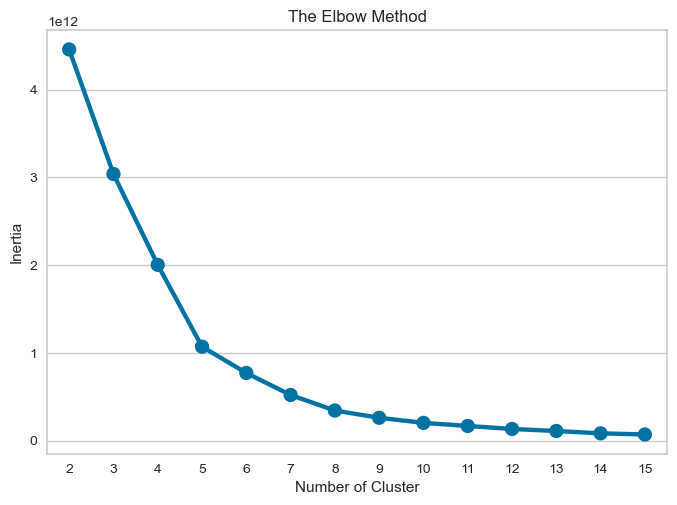

In [22]:
# Check results of elbow method

plt.title('The Elbow Method')
plt.xlabel('Number of Cluster')
plt.ylabel('Inertia')
sns.pointplot(x=list(wcss.keys()), y=list(wcss.values()))
plt.show()

In [23]:
# Locate the knee or elbow
cost_kneed = KneeLocator(x = K , y = list(wcss.values()) , S = 1.0 , curve = 'convex' , direction = 'decreasing' , online = True)
suggested_cluster = cost_kneed.elbow
print('Elbow at k = {} clusters'.format(suggested_cluster))

Elbow at k = 5 clusters


### Mathematical Method

C:\Users\Francia\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Francia\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Francia\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
C:\Users\Francia\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categ

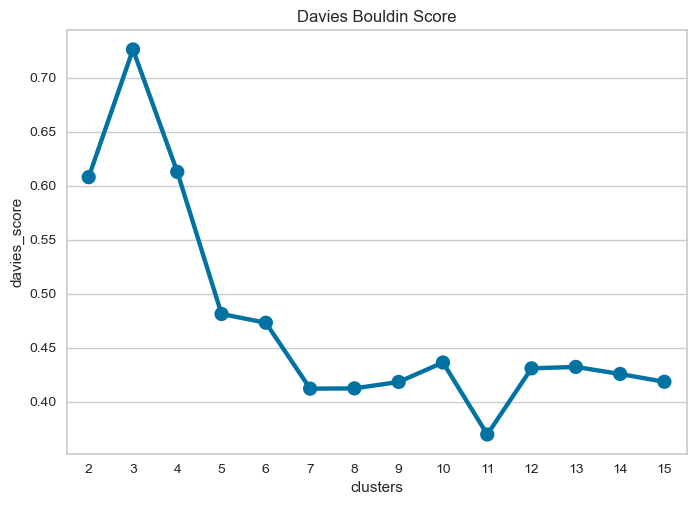

In [24]:
# Create plot for Davies-Bouldin score

plt.title('Davies Bouldin Score')
plt.xlabel('clusters')
plt.ylabel('davies_score')
sns.pointplot(x=list(davies_score.keys()), y=list(davies_score.values()))
plt.show()

C:\Users\Francia\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Francia\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Francia\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
C:\Users\Francia\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categ

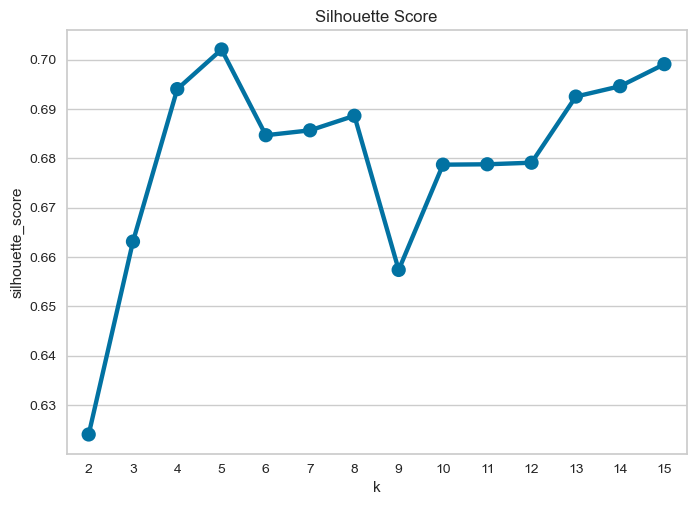

In [25]:
# Create plot for silhouette score

plt.title('Silhouette Score')
plt.xlabel('k')
plt.ylabel('silhouette_score')
sns.pointplot(x=list(ssc.keys()), y=list(ssc.values()))
plt.show()

In [26]:
# Create function for silhouette plot

def silhouette_plot(X , n_list):
    silhouette_scores = []
    for k in tqdm(n_list, desc='Progress'):
        #Instantiate model in k clusters
        model = KMeans(n_clusters = k, random_state=42, n_init=10)
        #Instantiate Visualizer model of with k clusters
        visualizer = SilhouetteVisualizer(model)
        #Fit data to the model
        visualizer.fit(X)
        #Draw data
        visualizer.poof()
        #Append score
        silhouette_scores.append([visualizer.silhouette_score_ , k])
    return silhouette_scores

Progress:   0%|                                                                                  | 0/1 [00:00<?, ?it/s]

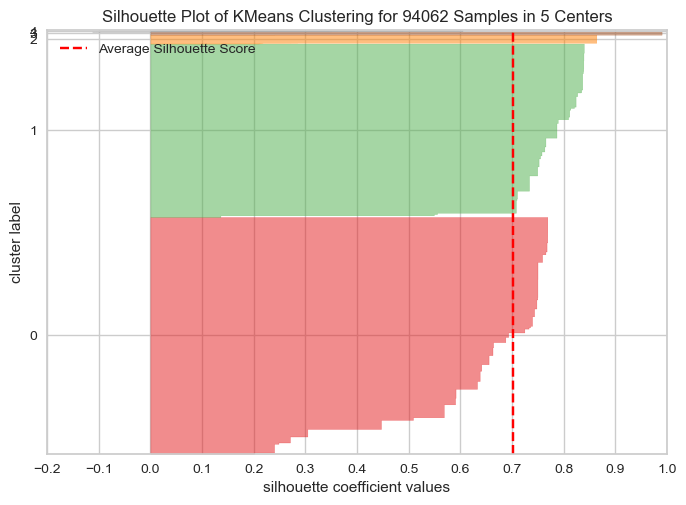

Progress: 100%|█████████████████████████████████████████████████████████████████████████| 1/1 [05:05<00:00, 305.10s/it]


[[0.702075050769129, 5]]

In [27]:
# Create silhouette plot

k_cluster_test = [5]

silhouette_plot(price_series_df , k_cluster_test)

## Clustering with chosen k

In [28]:
# Number of clusters (you can choose an appropriate value for your case)
n_clusters = 5

# Initialize K-means model
kmeans = KMeans(n_clusters=n_clusters, random_state=42)

# Fit the model to the data
kmeans.fit(price_series)

# Get cluster labels
cluster_labels = kmeans.labels_

C:\Users\Francia\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


### Snake plot

C:\Users\Francia\AppData\Local\Temp\ipykernel_27904\3315188144.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='variable', y='value', hue='Cluster_Labels', data=df_melted, marker='o', ci=None)
C:\Users\Francia\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Francia\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Francia\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.t

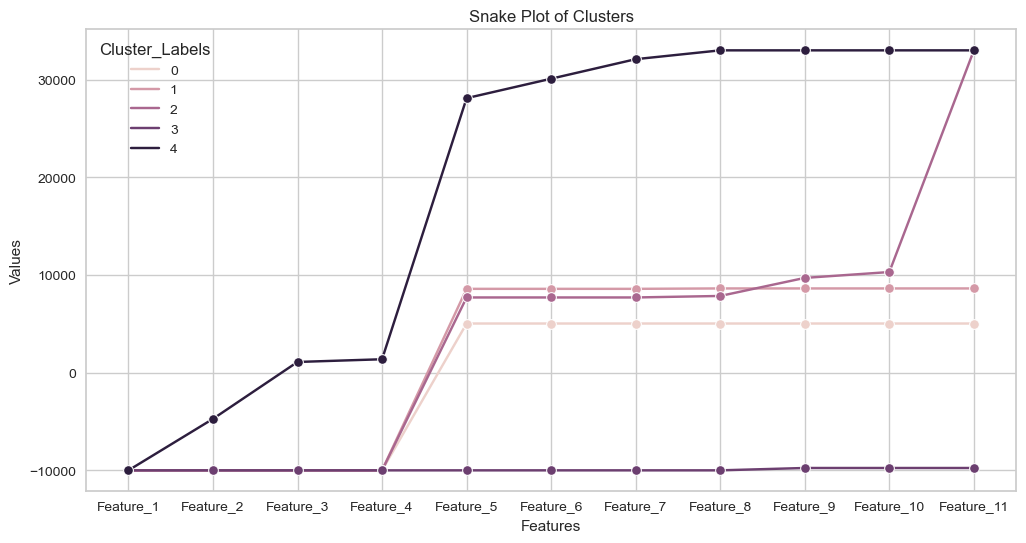

In [29]:
price_series_df['Cluster_Labels'] = cluster_labels

# Melt the DataFrame for the snake plot
df_melted = pd.melt(price_series_df, id_vars='Cluster_Labels', value_vars=price_series_df.columns[:-1])

# Create a snake plot using seaborn
plt.figure(figsize=(12, 6))
sns.lineplot(x='variable', y='value', hue='Cluster_Labels', data=df_melted, marker='o', ci=None)
plt.title('Snake Plot of Clusters')
plt.xlabel('Features')
plt.ylabel('Values')
plt.show()

### TSNE graph

C:\Users\Francia\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Francia\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Francia\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Francia\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.type

<Axes: title={'center': 'Flattened Graph of 6 Clusters'}>

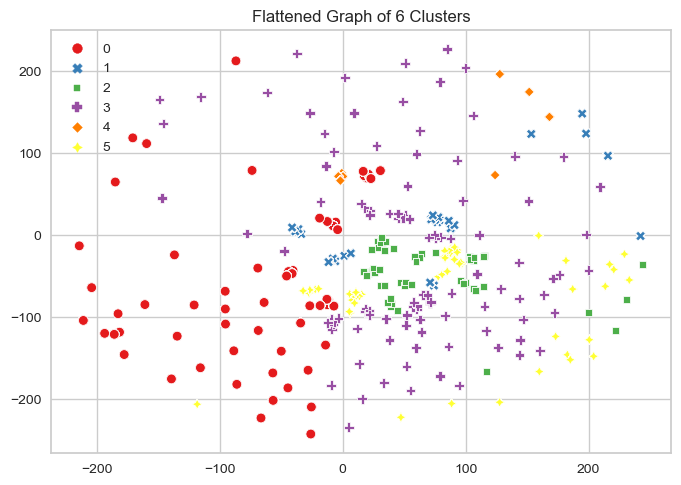

In [68]:
# # Initialise TSNE
# model = TSNE(random_state=1)
# transformed = model.fit_transform(price_series_df)

# # Plot t-SNE
# plt.title('Flattened Graph of {} Clusters'.format(n_clusters))
# sns.scatterplot(x=transformed[:,0], y=transformed[:,1], hue=cluster_labels, style=cluster_labels, palette="Set1")

### Count plot

C:\Users\Francia\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Francia\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Francia\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Francia\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.type

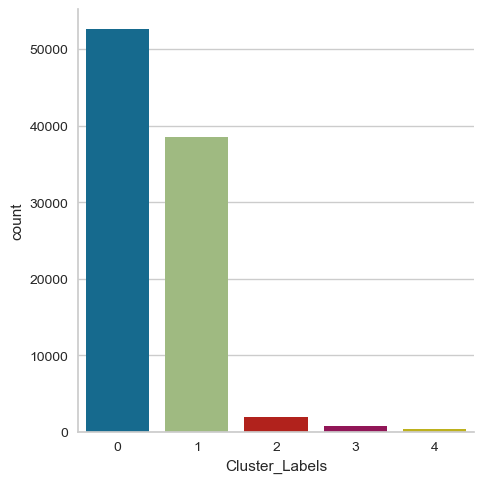

In [30]:
sns.catplot(
    data=price_series_df,
    x="Cluster_Labels",
    kind="count"
  )
plt.show()

## Stepwise Clustering

In [31]:
# # Define the quantity step
# quantity_step = 0.1

# # Define the range of quantities from 0 to 1 with the specified step
# quantities = np.arange(0, 1.1, quantity_step)

# # Extract the price columns
# price_columns = [f'Feature_{i}' for i in range(1, 12)]

# # Group by cluster labels
# grouped_clusters = price_series_df.groupby('Cluster_Labels')

# # Plot stepwise curves for each cluster
# for cluster, group in tqdm(grouped_clusters):
#     # Select the first 10000 curves or all if less than 10000
#     group = group.head(10000) if len(group) >= 10000 else group
    
#     # Plot stepwise curves
#     for index, row in group.iterrows():
#         prices = row[price_columns]
#         plt.step(quantities, prices, where='pre', color=f'C{cluster}', alpha=0.1, label=f'Cluster {cluster}')

# # Customize the plot
# plt.xlabel('Quantity')
# plt.ylabel('Price')
# #plt.legend(title='Clusters')
# plt.title('Stepwise Curves of Prices for Each Cluster')
# plt.show()


## Time Distribution Attempt

### Create a separate time distribution dataframe

In [32]:
time_distribution = df_2022.copy()

In [33]:
time_distribution.reset_index(drop=True, inplace=True)
time_distribution.head()

,run_time,price1,price2,price3,price4,price5,price6,price7,price8,price9,...,quantity2,quantity3,quantity4,quantity5,quantity6,quantity7,quantity8,quantity9,quantity10,quantity11
0,01/19/2022 09:00:00 AM,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,...,0.131868,0.131868,0.131868,0.131868,0.131868,0.131868,0.131868,0.131868,0.131868,0.131868
1,01/19/2022 09:05:00 AM,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,...,0.131868,0.131868,0.131868,0.131868,0.131868,0.131868,0.131868,0.131868,0.131868,0.131868
2,01/19/2022 09:10:00 AM,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,...,0.032967,0.032967,0.032967,0.032967,0.032967,0.032967,0.032967,0.032967,0.032967,0.032967
3,01/19/2022 09:15:00 AM,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,...,0.032967,0.032967,0.032967,0.032967,0.032967,0.032967,0.032967,0.032967,0.032967,0.032967
4,01/19/2022 09:20:00 AM,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,...,0.032967,0.032967,0.032967,0.032967,0.032967,0.032967,0.032967,0.032967,0.032967,0.032967


In [34]:
time_distribution = time_distribution[['run_time', 'price1']]
time_distribution.head()

,run_time,price1
0,01/19/2022 09:00:00 AM,-9999.0
1,01/19/2022 09:05:00 AM,-9999.0
2,01/19/2022 09:10:00 AM,-9999.0
3,01/19/2022 09:15:00 AM,-9999.0
4,01/19/2022 09:20:00 AM,-9999.0


In [35]:
# Assuming df is your DataFrame
split_values = time_distribution['run_time'].str.split(' ', n=1, expand=True)
time_distribution['date'] = split_values[0]
time_distribution['time'] = split_values[1].fillna('12:00:00 AM')
time_distribution.head()

,run_time,price1,date,time
0,01/19/2022 09:00:00 AM,-9999.0,01/19/2022,09:00:00 AM
1,01/19/2022 09:05:00 AM,-9999.0,01/19/2022,09:05:00 AM
2,01/19/2022 09:10:00 AM,-9999.0,01/19/2022,09:10:00 AM
3,01/19/2022 09:15:00 AM,-9999.0,01/19/2022,09:15:00 AM
4,01/19/2022 09:20:00 AM,-9999.0,01/19/2022,09:20:00 AM


In [36]:
time_distribution = time_distribution.drop(columns = ['run_time', 'price1'])
time_distribution.head()

,date,time
0,01/19/2022,09:00:00 AM
1,01/19/2022,09:05:00 AM
2,01/19/2022,09:10:00 AM
3,01/19/2022,09:15:00 AM
4,01/19/2022,09:20:00 AM


In [37]:
time_distribution['cluster_labels'] = cluster_labels
time_distribution.head()

,date,time,cluster_labels
0,01/19/2022,09:00:00 AM,4
1,01/19/2022,09:05:00 AM,4
2,01/19/2022,09:10:00 AM,4
3,01/19/2022,09:15:00 AM,4
4,01/19/2022,09:20:00 AM,4


In [38]:
#time_distribution['date'] = pd.to_datetime(time_distribution['date'])
#-- didn't push through with converting the date column to datetime kasi for some reason nawawala yung ibang months (see above block)

time_distribution['time'] = pd.to_datetime(time_distribution['time'], format='%I:%M:%S %p')
time_distribution['time'] = time_distribution['time'].dt.time

time_distribution.head()

,date,time,cluster_labels
0,01/19/2022,09:00:00,4
1,01/19/2022,09:05:00,4
2,01/19/2022,09:10:00,4
3,01/19/2022,09:15:00,4
4,01/19/2022,09:20:00,4


In [39]:
time_distribution['date'].value_counts()

date
12/20/2022    318
7/3/2022      288
8/29/2022     288
8/27/2022     288
8/26/2022     288
             ... 
01/19/2022    171
02/11/2022    156
02/02/2022    144
12/4/2022     132
9/24/2022      62
Name: count, Length: 330, dtype: int64

In [40]:
time_distribution['time'].value_counts()

time
18:20:00    359
21:45:00    330
22:40:00    330
21:15:00    330
21:20:00    330
           ... 
10:55:00    323
10:45:00    323
10:40:00    323
10:30:00    323
10:50:00    322
Name: count, Length: 288, dtype: int64

In [41]:
time_distribution['date'] = pd.to_datetime(time_distribution['date'])
time_distribution['date'].value_counts()

date
2022-12-20    318
2022-07-03    288
2022-08-29    288
2022-08-27    288
2022-08-26    288
             ... 
2022-01-19    171
2022-02-11    156
2022-02-02    144
2022-12-04    132
2022-09-24     62
Name: count, Length: 330, dtype: int64

In [42]:
time_distribution['month_year'] = time_distribution['date'].dt.to_period('M')
time_distribution['month_year'].value_counts()

month_year
2022-03    8928
2022-10    8927
2022-07    8926
2022-05    8910
2022-08    8813
2022-04    8636
2022-06    8623
2022-12    7938
2022-02    7788
2022-11    7131
2022-09    5815
2022-01    3627
Freq: M, Name: count, dtype: int64

In [43]:
# Convert time into number of minutes since 0:00:00
time_distribution['time'] = time_distribution['time'].astype(str)
time_distribution['time'] = pd.to_datetime(time_distribution['time'], format='%H:%M:%S').dt.time
time_distribution['time_minutes'] = time_distribution['time'].apply(lambda x: x.hour * 60 + x.minute)

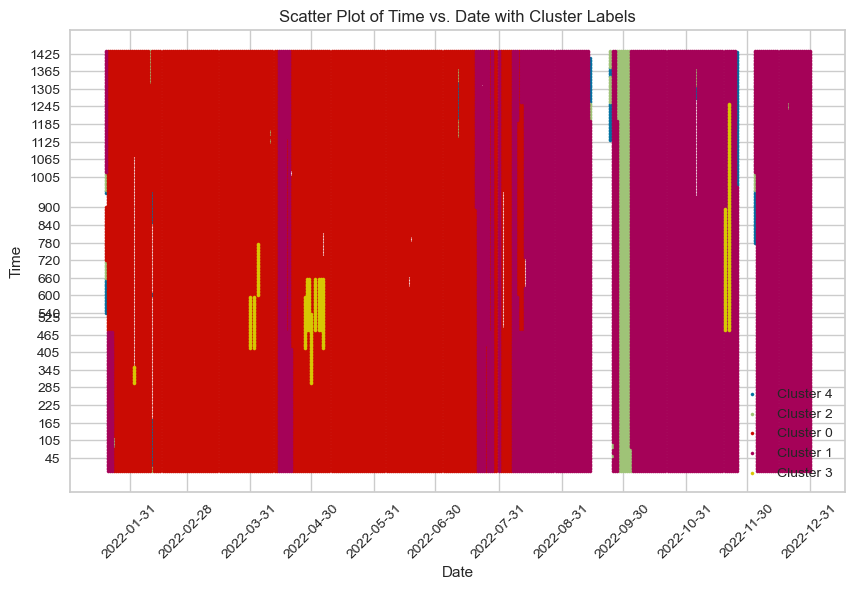

In [44]:
# Plot scatter plot
plt.figure(figsize=(10, 6))

# Use scatter plot with different colors for each cluster label
for cluster_labels in time_distribution['cluster_labels'].unique():
    cluster_data = time_distribution[time_distribution['cluster_labels'] == cluster_labels]
    plt.scatter(cluster_data['date'], cluster_data['time_minutes'], label=f'Cluster {cluster_labels}', s=5)

# Set labels and title
plt.xlabel('Date')
plt.ylabel('Time')
plt.title('Scatter Plot of Time vs. Date with Cluster Labels')
plt.legend()

x_ticks = time_distribution['month_year'].unique()  
y_ticks = time_distribution['time_minutes'].unique()[::12]  
plt.xticks(x_ticks, rotation=45)
plt.yticks(y_ticks)

# Show the plot
plt.show()

In [45]:
# Generate a range of expected dates
expected_dates = pd.date_range(start='2022-01-01', end='2022-12-31')

# Find missing dates by comparing the expected dates with the actual dates
missing_dates = expected_dates[~expected_dates.isin(time_distribution['date'].unique())]

# Print the missing dates
print("Missing dates:", missing_dates)

Missing dates: DatetimeIndex(['2022-01-01', '2022-01-02', '2022-01-03', '2022-01-04',
               '2022-01-05', '2022-01-06', '2022-01-07', '2022-01-08',
               '2022-01-09', '2022-01-10', '2022-01-11', '2022-01-12',
               '2022-01-13', '2022-01-14', '2022-01-15', '2022-01-16',
               '2022-01-17', '2022-01-18', '2022-09-15', '2022-09-16',
               '2022-09-17', '2022-09-18', '2022-09-19', '2022-09-20',
               '2022-09-21', '2022-09-22', '2022-09-23', '2022-11-26',
               '2022-11-27', '2022-11-28', '2022-11-29', '2022-11-30',
               '2022-12-01', '2022-12-02', '2022-12-03'],
              dtype='datetime64[ns]', freq=None)
